In [1]:
%matplotlib inline
from random import randint, choice, seed
import os
import sys
def sizeof(obj):
    size = sys.getsizeof(obj)
    if isinstance(obj, dict): return size + sum(map(sizeof, obj.keys())) + sum(map(sizeof, obj.values()))
    if isinstance(obj, (list, tuple, set, frozenset)): return size + sum(map(sizeof, obj))
    return size

def print_last_query(G):
    log = G.helper.sql_logger
    act = log.active
    log.active = True
    log(log.buffer[-1])
    log.active = act
from networkdisk.tupledict.currying import fold, unfold

# NetworkDisk: On disk graph manipulation

### - Authors

- [Bruno Guillon](???)
- [Charles Paperman](paperman.name)


### - Outline

1. A brief presentation of [NetworkX](https://networkx.org/)
2. A quick presentation of [NetworkDisk](https://networkdisk.inria.fr)
3. Under The Hood
4. A complete example
5. Playing with DBLP graph for fun

# 1. A brief presentation of NetworkX


- `NetworkX` is among the most popular Python package.
- It is a module that provides many (many!) graphs algorithms

- Some contributors are from academia
- The documentation contains bibliographical references

- Unfortunately, it is **not** really data oriented

## A quick example

In [2]:
import networkx as nx # We import the module

In [3]:
import matplotlib.pyplot as plot

We build circle line graph (not very interesting, I know) 

In [4]:
LineGraph = nx.Graph()
LineGraph.add_edges_from([(i, i+1, {"w":i}) for i in range(8)])
LineGraph.add_edge(8, 9, w=8)

It is a non-directed graph, so although we insert oriented edges, it is stored in a symetric fashion:

In [5]:
(0, 1) in LineGraph.edges

True

In [6]:
(1, 0) in LineGraph.edges

True

We can get all nodes connected to 1, with the data-values of the edges.

In [7]:
LineGraph[1]

AtlasView({0: {'w': 0}, 2: {'w': 1}})

We can test more complicated properties:

In [8]:
nx.is_tree(LineGraph)

True

In [9]:
nx.is_connected(LineGraph)

True

In [10]:
LineGraph.add_node(10) # Add some isolated nodes

In [11]:
nx.is_connected(LineGraph)

False

Or draw it:

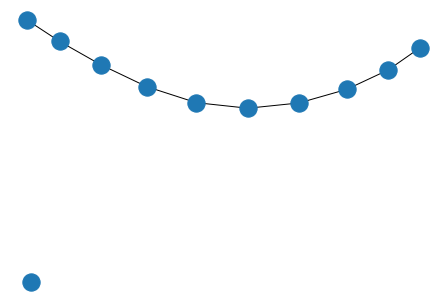

In [12]:
nx.draw(LineGraph)
plot.show()

We can handle also DiGraph.

In [13]:
LineDiGraph = nx.DiGraph()
LineDiGraph.add_edges_from([(i, i+1) for i in range(10)])

This time, edges are indeed oriented:

In [14]:
(0, 1) in LineDiGraph.edges

True

In [15]:
(1, 0) in LineDiGraph.edges

False

## NetworkX as a Graph Manipulation API

- NetworkX is used as a standard interface for Graph, DiGraph with or without Data in Python
- It is actually one of its main usage in DataScience/Graph related topics
- For instance: famous [Node2Vec](https://github.com/eliorc/node2vec) bindings in Python uses NetworkX

## Data model and updates operations

- To modify the graph, 4 methods exists. Two for adding *one* node or *one* edge and two for their bulk variants.
- A NetworkX (Di)Graph is a Data-Graph with *documents* on each node and each edge


### One node insert

To add an element to a Graph or to update its data-values, we can use `add_node` method.

In [16]:
LineGraph.add_node(
    1, 
    Graphs="Are Cool", 
    Monoids="Are also nice")

In [17]:
LineGraph.nodes[1]

{'Graphs': 'Are Cool', 'Monoids': 'Are also nice'}

### Many nodes insert

Bulk-insert can be performed with `add_nodes_from`. 
It allows to add many nodes at once, with global and local data values to insert.

In [18]:
LineGraph.add_nodes_from(
    [(2, {"Key":"Key of 2"}), 
    3,
    4,
    5], 
    Other="Something Else")

In [19]:
LineGraph.nodes[2]

{'Other': 'Something Else', 'Key': 'Key of 2'}

In [20]:
LineGraph.nodes[3]

{'Other': 'Something Else'}

## Data Values

* Supported data Values are actually any Python object.
* Keys are any key supported by dict-like object (*hashable elements*)

In [21]:
LineGraph.add_node(4, complexe_data={"This":{"is":["nested", "data-values"]}})
LineGraph.nodes[4]

{'Other': 'Something Else',
 'complexe_data': {'This': {'is': ['nested', 'data-values']}}}

Data is passed *by reference*.
It simply store the pointer to the data provided:
* no *copy* is perfomed
* no constrained on the kind of data used

In [22]:
d = LineGraph.nodes[4] # Just a dictionnary
d["new"] = "data"
LineGraph.nodes[4]

{'Other': 'Something Else',
 'complexe_data': {'This': {'is': ['nested', 'data-values']}},
 'new': 'data'}

### Edge insertions

Edges insertions follows a similar principle with two methods `add_edge` and `add_edges_from`.
Edges insertions methods also add non-existing node to the graph.

Their DataValues are similar to those for nodes.

We have already see `add_edges_from` without any data, lets see on one example.


In [23]:
LineGraph.add_edge(0, 1, foo="bar")
LineGraph.add_edges_from([(i, i+1, {"w":randint(0, 10)}) for i in range(10)])

In [24]:
LineGraph.edges[(0, 1)]

{'w': 8, 'foo': 'bar'}

In [25]:
LineGraph.edges[(1, 2)]

{'w': 10}

Or equivalentely

In [26]:
LineGraph[1][2]

{'w': 10}

Adding edges automatically refresh nodes:

In [27]:
print(42 in LineGraph.nodes)
LineGraph.add_edge(42, 43)
print(43 in LineGraph.nodes)

False
True


## Reading/Querying the graph

### Simple Graph access

Access to get primitive data extraction from the graph.

In [28]:
LineGraph.nodes[1] # node data

{'Graphs': 'Are Cool', 'Monoids': 'Are also nice'}

In [29]:
LineGraph.adj[1] # Neighbors of 1, along with edge data.

AtlasView({0: {'w': 8, 'foo': 'bar'}, 2: {'w': 10}})

In [30]:
LineGraph.adj[1]

AtlasView({0: {'w': 8, 'foo': 'bar'}, 2: {'w': 10}})

### Graph *traversal* extraction

It is possible also to extract some global informations from the graph, that are often useful:

In [31]:
LineGraph.degree() # degree of Each node

DegreeView({0: 1, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 1, 42: 1, 43: 1})

Those extraction can be dependent of the data values:

In [32]:
LineGraph.degree(weight="w")

DegreeView({0: 8, 1: 18, 2: 14, 3: 12, 4: 14, 5: 9, 6: 11, 7: 15, 8: 15, 9: 9, 10: 1, 42: 1, 43: 1})

Other manipulations is possible like:

* subgraph views
* mapping directed graph to undirected and vice versa with some constraints

### NetworkX documentation on algorithms

NetworkX provides a lot of algorithms (hundreds really), that are well documented.

For instance, to doc of the `betweenness_centrality`:

Compute the shortest-path betweenness centrality for nodes.

    Betweenness centrality of a node $v$ is the sum of the
    fraction of all-pairs shortest paths that pass through $v$

    .. math::

       c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}

    where $V$ is the set of nodes, $\sigma(s, t)$ is the number of
    shortest $(s, t)$-paths,  and $\sigma(s, t|v)$ is the number of
    those paths  passing through some  node $v$ other than $s, t$.
    If $s = t$, $\sigma(s, t) = 1$, and if $v \in {s, t}$,
    $\sigma(s, t|v) = 0$ [2]_.

    Parameters
    ----------
    G : graph
      A NetworkX graph.

    k : int, optional (default=None)
      If k is not None use k node samples to estimate betweenness.
      The value of k <= n where n is the number of nodes in the graph.
      Higher values give better approximation.

    normalized : bool, optional
      If True the betweenness values are normalized by `2/((n-1)(n-2))`
      for graphs, and `1/((n-1)(n-2))` for directed graphs where `n`
      is the number of nodes in G.

    weight : None or string, optional (default=None)
      If None, all edge weights are considered equal.
      Otherwise holds the name of the edge attribute used as weight.

    endpoints : bool, optional
      If True include the endpoints in the shortest path counts.

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
        Note that this is only used if k is not None.

    Returns
    -------
    nodes : dictionary
       Dictionary of nodes with betweenness centrality as the value.

    See Also
    --------
    edge_betweenness_centrality
    load_centrality

    Notes
    -----
    The algorithm is from Ulrik Brandes [1]_.
    See [4]_ for the original first published version and [2]_ for details on
    algorithms for variations and related metrics.

    For approximate betweenness calculations set k=#samples to use
    k nodes ("pivots") to estimate the betweenness values. For an estimate
    of the number of pivots needed see [3]_.

    For weighted graphs the edge weights must be greater than zero.
    Zero edge weights can produce an infinite number of equal length
    paths between pairs of nodes.

    The total number of paths between source and target is counted
    differently for directed and undirected graphs. Directed paths
    are easy to count. Undirected paths are tricky: should a path
    from "u" to "v" count as 1 undirected path or as 2 directed paths?

    For betweenness_centrality we report the number of undirected
    paths when G is undirected.

    For betweenness_centrality_subset the reporting is different.
    If the source and target subsets are the same, then we want
    to count undirected paths. But if the source and target subsets
    differ -- for example, if sources is {0} and targets is {1},
    then we are only counting the paths in one direction. They are
    undirected paths but we are counting them in a directed way.
    To count them as undirected paths, each should count as half a path.

    References
    ----------
    .. [1] Ulrik Brandes:
       A Faster Algorithm for Betweenness Centrality.
       Journal of Mathematical Sociology 25(2):163-177, 2001.
       http://www.inf.uni-konstanz.de/algo/publications/b-fabc-01.pdf
    .. [2] Ulrik Brandes:
       On Variants of Shortest-Path Betweenness
       Centrality and their Generic Computation.
       Social Networks 30(2):136-145, 2008.
       http://www.inf.uni-konstanz.de/algo/publications/b-vspbc-08.pdf
    .. [3] Ulrik Brandes and Christian Pich:
       Centrality Estimation in Large Networks.
       International Journal of Bifurcation and Chaos 17(7):2303-2318, 2007.
       http://www.inf.uni-konstanz.de/algo/publications/bp-celn-06.pdf
    .. [4] Linton C. Freeman:
       A set of measures of centrality based on betweenness.
       Sociometry 40: 35–41, 1977
       http://moreno.ss.uci.edu/23.pdf

##  Conclusion on NetworkX

* A state of the art *classical Graph* manipulation librairies
* Documentations is good
* The user base is huge

## NetworkX limitation

1. NetworkX is mostly used to apply standard graph algorithms, no implementation on data-specific queries

2.  NetworkX allows manipulation of nodes and edges with data values, but does not index it nor perform specific algorithms with those.

3. For very large Graph, the memory footprint of `NetworkX` is also a killer as we will see.

Meet: **NetworkDisk**.

# 2. NetworkDisk

## Problematic:  To*transform* NetworkX into a *straigh-forward-to-use* **Graph Database**


## Advantage:

1. To allow (very) large graph manipulation
2. (Almost) complete compatibility with NetworkX
3. Add a data-manipulation interface
4. Inherit ACIDity from backend
5. Overall more concise for the same data

## Drawbacks

1. Performance penalty from converting hierarchical data into tabular data for each operation.
2. Performance penalty from writing/reading on disk

## Current status

* NetworkDisk can be think as a specific `ORM` for Graphs
* Compatibility is ensure by using `UnitTest` from NetworkX
* It relies only relational Database backend

* So far handle only SQLite backend ... 
* ... but the code can be easily adapted for PostgreSQL/Oracle backend

* Can be extended to distributed column stores to get a distributed Graph database engine.


## Playing with some small examples first

In [33]:
import networkdisk as nd

We can create a *in-memory* SQLite-based Graph 

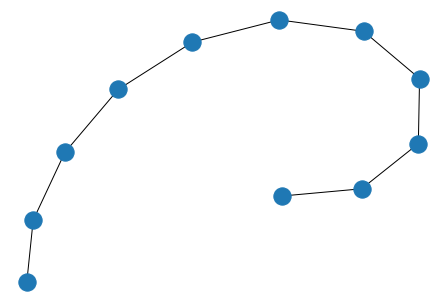

In [34]:
SQLLineGraph = nd.sqlite.Graph()
SQLLineGraph.add_edges_from([(i, i+1) for i in range(10)])
nx.draw(SQLLineGraph)

In [35]:
SQLLineGraph.add_node(10, monoid="are beautiful", graph="are not bad either")
SQLLineGraph.nodes[10]

{graph: 'are not bad either', monoid: 'are beautiful'}

We can activate the *Logger* to check what is the interaction with the database.

In [36]:
SQLLineGraph.helper.sql_logger.active = True

In [37]:
SQLLineGraph.helper.sql_logger._max_length = 70

In [38]:
SQLLineGraph.add_node(11, 
                      monoid="are beautifuls", 
                      graph="are not bad either",
                      automata="are ... meh"
                     )

<SQL>: BEGIN TRANSACTION
<SQL>: SELECT COUNT(?) FROM nodes1 WHERE name = ? LIMIT 1
<SQL>: --- 			↖ 1, 11
<SQL>: DELETE FROM nodes1 WHERE name = ?
<SQL>: --- 			↖ 11 … 11m
<SQL>: INSERT INTO nodes1(name) VALUES (?)
<SQL>: --- 			↖ 11
<SQL>: INSERT INTO node_data1(name, key, value) SELECT name, ?, ? FROM nodes1 WHERE name = ?
<SQL>: --- 			↖ "monoid","are beautifuls",11 … "automata","are ... me…
<SQL>: COMMIT TRANSACTION


In [39]:
dict(SQLLineGraph.nodes[11])

<SQL>: SELECT COUNT(?) FROM nodes1 WHERE name = ? LIMIT 1
<SQL>: --- 			↖ 1, 11
<SQL>: SELECT DISTINCT key FROM nodes1 INNER JOIN node_data1 ON nodes1.name = node_data1.name WHERE key IS NOT NULL AND nodes1.name = ?
<SQL>: --- 			↖ 11
<SQL>: SELECT value FROM nodes1 LEFT JOIN node_data1 ON nodes1.name = node_data1.name WHERE nodes1.name = ? AND key = ?
<SQL>: --- 			↖ 11, "automata"
<SQL>: SELECT value FROM nodes1 LEFT JOIN node_data1 ON nodes1.name = node_data1.name WHERE nodes1.name = ? AND key = ?
<SQL>: --- 			↖ 11, "graph"
<SQL>: SELECT value FROM nodes1 LEFT JOIN node_data1 ON nodes1.name = node_data1.name WHERE nodes1.name = ? AND key = ?
<SQL>: --- 			↖ 11, "monoid"


{'automata': 'are ... meh',
 'graph': 'are not bad either',
 'monoid': 'are beautifuls'}

It produces a lot of queries, because the `dict` object that will fetch for each key the associated value, which is
done with one query for each.

It is possible to use some optimization here by iterating on key, value and building the graph
at once.

In [40]:
dict(SQLLineGraph.nodes[11].items())

<SQL>: SELECT COUNT(?) FROM nodes1 WHERE name = ? LIMIT 1
<SQL>: --- 			↖ 1, 11
<SQL>: SELECT DISTINCT key, value FROM nodes1 INNER JOIN node_data1 ON nodes1.name = node_data1.name WHERE key IS NOT NULL AND nodes1.name = ? ORDER BY node_data1.name
<SQL>: --- 			↖ 11


{'automata': 'are ... meh',
 'graph': 'are not bad either',
 'monoid': 'are beautifuls'}

It is unpleasant, but hard to avoid that some basic Python constructor can't be optimized with our `ORM`, which makes it unfriendly in some way... but as any `ORM`.

[See Object–relational impedance mismatch](https://en.wikipedia.org/wiki/Object%E2%80%93relational_impedance_mismatch)

# 3. Under the hood

# NetworkX: bounded recursive *dictionnary* all the way down

* The underlying data-structure of NetworkX is `dict-of-dict-of-dict`, that is a tree of detph 3!
* Tree-shape datastructure are not really friendly with relational based data we want to use!



For instance, nodes and nodes data are stored in the `._node` dict-of-dict.

In [41]:
LineGraph._node

{0: {},
 1: {'Graphs': 'Are Cool', 'Monoids': 'Are also nice'},
 2: {'Other': 'Something Else', 'Key': 'Key of 2'},
 3: {'Other': 'Something Else'},
 4: {'Other': 'Something Else',
  'complexe_data': {'This': {'is': ['nested', 'data-values']}},
  'new': 'data'},
 5: {'Other': 'Something Else'},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 42: {},
 43: {}}

For instance, edges and edge data are store in the `_adj` dict-of-dict-of-dict.

In [42]:
LineGraph._adj

{0: {1: {'w': 8, 'foo': 'bar'}},
 1: {0: {'w': 8, 'foo': 'bar'}, 2: {'w': 10}},
 2: {1: {'w': 10}, 3: {'w': 4}},
 3: {2: {'w': 4}, 4: {'w': 8}},
 4: {3: {'w': 8}, 5: {'w': 6}},
 5: {4: {'w': 6}, 6: {'w': 3}},
 6: {5: {'w': 3}, 7: {'w': 8}},
 7: {6: {'w': 8}, 8: {'w': 7}},
 8: {7: {'w': 7}, 9: {'w': 8}},
 9: {8: {'w': 8}, 10: {'w': 1}},
 10: {9: {'w': 1}},
 42: {43: {}},
 43: {42: {}}}

To transform a `NetworkX` Graph into a Graph within a relational database, we *only* need to find
an appropriate representations for those data-structures.

## TupleDict: from bounded tree to relational representation


The abstract problem can be think as: 

### How to represent efficiently `(dict-of)ⁿ-dict` *trees* in a relational database?



An obvious solution: **decurrying it** !!

In [43]:
adj_fold = list(unfold(LineGraph._adj))
adj_fold[:6]

[(0, 1, 'w', 8),
 (0, 1, 'foo', 'bar'),
 (1, 0, 'w', 8),
 (1, 0, 'foo', 'bar'),
 (1, 2, 'w', 10),
 (2, 1, 'w', 10)]

This is closer of what we could store in a database.

The converse operation is easy to perform as well: 

In [44]:
fold(list(unfold(LineGraph._adj))) 

{0: {1: {'w': {8: {}}, 'foo': {'bar': {}}}},
 1: {0: {'w': {8: {}}, 'foo': {'bar': {}}}, 2: {'w': {10: {}}}},
 2: {1: {'w': {10: {}}}, 3: {'w': {4: {}}}},
 3: {2: {'w': {4: {}}}, 4: {'w': {8: {}}}},
 4: {3: {'w': {8: {}}}, 5: {'w': {6: {}}}},
 5: {4: {'w': {6: {}}}, 6: {'w': {3: {}}}},
 6: {5: {'w': {3: {}}}, 7: {'w': {8: {}}}},
 7: {6: {'w': {8: {}}}, 8: {'w': {7: {}}}},
 8: {7: {'w': {7: {}}}, 9: {'w': {8: {}}}},
 9: {8: {'w': {8: {}}}, 10: {'w': {1: {}}}},
 10: {9: {'w': {1: {}}}},
 42: {43: {}},
 43: {42: {}}}

By default, if we do not specifies the depth, it will try to unfold at infinity. Here, we just want that it unfold
up to depth 3.

In [45]:
fold(list(unfold(LineGraph._adj)), maxdepth=3)

{0: {1: {'w': 8, 'foo': 'bar'}},
 1: {0: {'w': 8, 'foo': 'bar'}, 2: {'w': 10}},
 2: {1: {'w': 10}, 3: {'w': 4}},
 3: {2: {'w': 4}, 4: {'w': 8}},
 4: {3: {'w': 8}, 5: {'w': 6}},
 5: {4: {'w': 6}, 6: {'w': 3}},
 6: {5: {'w': 3}, 7: {'w': 8}},
 7: {6: {'w': 8}, 8: {'w': 7}},
 8: {7: {'w': 7}, 9: {'w': 8}},
 9: {8: {'w': 8}, 10: {'w': 1}},
 10: {9: {'w': 1}},
 42: {43: {}},
 43: {42: {}}}

1. We can easily store that into tables by padding with `NULL` values
2. But it requires a bit of thinking if we want to factorize and normalize the database appropriately
3. A *kind of* algebraic object specifics how to perform the mapping

# TupleDict's Schema

A TupleDict schema is a *mapping* from a *recursive dict* to a relation signature.
Such a mapping has to support various *operations*

![mapping](img/mapping.png)

### Overlapping

![overlap](img/overlap.png)

### Swaping depths

![swap](img/swap.png)

### Prunings subtrees

![prune](img/prune.png)

# Playing with TupleDict

In NetworkDisk, we provide several TupleDict to play with. In the default schema: 

In [46]:
SQLLineGraph.schema.nodes.subqueries

(SchemaTable<nodes1(name)>, SchemaTable<node_data1(name, key, value)>)

In [47]:
SQLLineGraph.schema.edgestore.subqueries

(SchemaView<symedges1(id, source, target)>,
 SchemaTable<edge_data1(id, key, value)>)

Those object contains information on sub-relations and how to perform the join to get the desired result.

The `edgestore` store only edges occuring, but NetworkX requires the adjencency recursive dict. We built it automtically using algebraic operation on TupleDict.

In [48]:
SQLLineGraph.schema.adj.subqueries

(SchemaTable<nodes1(name)>,
 SchemaView<symedges1(id, source, target)>,
 SchemaTable<edge_data1(id, key, value)>)

Our goal is to keep this as generic as possible so we can define complicate such mapping.

Some *ready-to-use* schemas are available in the project with different split among the columns.

In [49]:
splitted = nd.sqlite.sqlitedialect.schemata.digraph_splitted()

In [50]:
splitted.edgestore.subqueries

(SchemaTable<edge_sources(source)>,
 SchemaTable<edge_targets(id, source, target)>,
 SchemaTable<edge_keys(id, edge, key)>,
 SchemaTable<edge_values(fid, value)>)

In [51]:
splitted.adj.subqueries

(SchemaTable<node_names(name)>,
 SchemaTable<edge_sources(source)>,
 SchemaTable<edge_targets(id, source, target)>,
 SchemaTable<edge_keys(id, edge, key)>,
 SchemaTable<edge_values(fid, value)>)

## Handling references

NetworkX data inherit from Python: hence subdictionnary/list/set are *references*. 
We preserve this semantic only partially, and it is hard to avoid this pitfall.

In [52]:
data_of_11 = SQLLineGraph.nodes[11]
data_of_11["new"] = "data"

<SQL>: BEGIN TRANSACTION
<SQL>: SELECT COUNT(?) FROM nodes1 INNER JOIN node_data1 ON nodes1.name = node_data1.name WHERE nodes1.name = ? AND key = ? LIMIT 1
<SQL>: --- 			↖ 1, 11, null
<SQL>: DELETE FROM node_data1 WHERE key = ? AND name IN (SELECT name FROM nodes1 WHERE name = ?)
<SQL>: --- 			↖ "new",11 … "new",11m
<SQL>: INSERT INTO nodes1(name) VALUES (?)
<SQL>: --- 			↖ 11
<SQL>: INSERT INTO node_data1(name, key, value) SELECT name, ?, ? FROM nodes1 WHERE name = ?
<SQL>: --- 			↖ "new","data",11 … "new","data",11m
<SQL>: COMMIT TRANSACTION


In [53]:
SQLLineGraph.helper.sql_logger.active = False

In [54]:
data_of_11

{automata: 'are ... meh', graph: 'are not bad either', monoid: 'are beautifuls', …}

Because of some encoding behavour, we do not nest this behaviour by default, which is a *divergence* with
NetworkX: up to a certain *depth*, data is considered as non-mutable implicitely.

By default, this depth is *1*.


In [55]:
k = {"age": 1}
data_of_11["foo"] = k

We assign a Python dictionnary to some key.

If we change later the content of k, it will not be updated.

In [56]:
k["age"] = 2
data_of_11["foo"]

{'age': 1}

# 4. A more complete example


We will play with actual *On Disk* Graph now and try to insert more datas.
We first define some `edges` and `nodes`.

In [57]:
n = 1000

colors = ["red", "blue", "green", "purple"]

nodes = [
    (i, {"mod42":i%42, "color":choice(colors)})
    for i in range(n)
]

edges = [
    (randint(0, n), randint(0, n), {"weight":randint(0, 10), "color":choice(colors)}) 
    for _ in range(n*n)
]

We create an *actual* on disk graph. The keyword `:tempfile:` is simply to avoid to provide an explicit path.

In [58]:
G = nd.sqlite.Graph(db=":tempfile:")

In [59]:
G.helper.sql_logger.active = True

In [60]:
G.add_nodes_from(nodes)

<SQL>: BEGIN TRANSACTION
<SQL>: INSERT INTO nodes(name) VALUES (?)
<SQL>: --- 			↖ 0 … 999
<SQL>: INSERT INTO node_data(name, key, value) SELECT name, ?, ? FROM nodes WHERE name = ?
<SQL>: --- 			↖ "mod42",0,0 … "color","purple",999
<SQL>: COMMIT TRANSACTION


In [61]:
G.add_edges_from(edges)

<SQL>: BEGIN TRANSACTION
<SQL>: INSERT INTO edges(source, target) VALUES (?, ?)
<SQL>: --- 			↖ 1,178 … 682,697m
<SQL>: INSERT INTO nodes(name) SELECT source FROM symedges UNION ALL SELECT target FROM symedges
<SQL>: INSERT INTO edge_data(id, key, value) SELECT id, ?, ? FROM edges WHERE source = ? AND target = ?
<SQL>: --- 			↖ "weight",10,1,178 … "color","purple",682,697
<SQL>: COMMIT TRANSACTION


In [62]:
nxG = nx.Graph()
nxG.add_nodes_from(nodes)
nxG.add_edges_from(edges)

We can compare their *memory footprint*

In [63]:
def networkdisk_size(inG):
    with open(inG.helper.dbpath) as f:
        return os.fstat(f.fileno()).st_size//10**6+1
def networkx_size(inG):
        return (sizeof(inG._adj)+sizeof(inG._node))//10**6+1

In [64]:
print("NetworkDisk", "Graph size on disk:", networkdisk_size(G), "Mo")
print("NetworkX", "Graph size on RAM:", networkx_size(nxG), "Mo")

NetworkDisk Graph size on disk: 112 Mo
NetworkX Graph size on RAM: 428 Mo


## Data querying

In NetworkDisk, it is possible to fetch some Data through a custom interface:

In [65]:
bunch = G.find_all_nodes(color="blue", mod42=lambda c:c.inset(0, 1, 2, 3))

The resulting object is something that allow to manipulate both the query and its replies.

In [66]:
sorted(bunch)[:8]

<SQL>: SELECT name FROM (SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value IN (?, ?, ?, ?)) INTERSECT SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value = ?))
<SQL>: --- 			↖ "mod42", 0, 1, 2, 3, "color", "blue"


[0, 42, 43, 44, 84, 254, 379, 462]

In [67]:
some_node = next(iter(bunch))
print(some_node)

<SQL>: SELECT name FROM (SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value IN (?, ?, ?, ?)) INTERSECT SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value = ?))
<SQL>: --- 			↖ "mod42", 0, 1, 2, 3, "color", "blue"
0


We can use thoses queries to define implicit sub-Graph. This operation doesn't actually move *any* data around. 
It is just the construction of a *Graph to SQL mapping*, which depends of the query we provide

In [68]:
G.helper.sql_logger.active = False

In [69]:
subG = G.subgraph(bunch)
nxsubG = nxG.subgraph(bunch)
subG.number_of_edges()

277

The query produced, start to be slightly more complicated:

In [70]:
print_last_query(G)

<SQL>: WITH node_domain AS (SELECT name FROM nodes WHERE name IN (SELECT name FROM (SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value IN (?, ?, ?, ?)) INTERSECT SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value = ?)))) SELECT COUNT(?) FROM (SELECT source, target FROM symedges WHERE source <= target AND source IN node_domain AND target IN node_domain)
<SQL>: --- 			↖ key:?:mod42, value:?:0, value:?:1, value:?:2, value:?:3, key:?:col …


In [71]:
print(sorted(subG[some_node])[:10])
print(sorted(nxsubG[some_node])[:10])

[0, 42, 43, 44, 84, 254, 379, 462, 505, 506]
[0, 42, 43, 44, 84, 254, 379, 462, 505, 506]


## Graph global properties

Degrees computations (among other) are computed without iterating over all the graph sequentially.


In [72]:
G.degree(weight="mod42")

DegreeView({0: 843, 1: 849, 10: 871, …})

The query: 

In [73]:
print_last_query(G)

<SQL>: SELECT name, SUM(degree) FROM (SELECT name, SUM(IIF(target IS NOT NULL, CAST(IFNULL(value, ?) AS NUMERIC), ?)) AS degree FROM nodes INNER JOIN symedges ON name = source LEFT JOIN edge_data ON symedges.id = edge_data.id AND key = ? WHERE target IS NOT NULL AND name != target GROUP BY name UNION ALL SELECT name, SUM(IIF(target IS NOT NULL, CAST(IFNULL(value, ?) AS NUMERIC), ?))*? AS degree FROM nodes LEFT JOIN symedges ON name = source LEFT JOIN edge_data ON symedges.id = edge_data.id AND key = ? WHERE name = target GROUP BY name) AS partial_aggregate GROUP BY name LIMIT 4
<SQL>: --- 			↖ value:?:1.0, ?:0, key:?:mod42, value:?:1.0, ?:0, ?:2, key:?:mod42


We can do the same for the subgraph:

In [74]:
subG.degree(weight="mod42")

DegreeView({0: 25, 1000: 22, 254: 22, …})

And the query is even more awfull: 

In [75]:
print_last_query(G)

<SQL>: WITH node_domain AS (SELECT name FROM nodes WHERE name IN (SELECT name FROM (SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value IN (?, ?, ?, ?)) INTERSECT SELECT nodes.name FROM nodes LEFT JOIN node_data ON nodes.name = node_data.name AND key = ? WHERE nodes.name IS NOT NULL AND (key IS NULL OR value = ?)))) SELECT name, SUM(degree) FROM (SELECT name, SUM(IIF(target IS NOT NULL, CAST(IFNULL(value, ?) AS NUMERIC), ?)) AS degree FROM nodes INNER JOIN symedges ON name = source AND source IN node_domain AND target IN node_domain LEFT JOIN edge_data ON symedges.id = edge_data.id AND key = ? WHERE target IS NOT NULL AND name != target AND name IN node_domain GROUP BY name UNION ALL SELECT name, SUM(IIF(target IS NOT NULL, CAST(IFNULL(value, ?) AS NUMERIC), ?))*? AS degree FROM nodes INNER JOIN symedges ON name = source AND source IN node_domain AND target IN node_domain LEFT JOIN edge_data 

# 5. Playing with DBLP graph for fun

We can play with DBLP example. A recent version can be download [here](https://links-biblio.lille.inria.fr/networkdisk/dblp.db) (around 7Go to download).

In [76]:
dblp = nd.sqlite.Graph(db="dblp.db")

In [77]:
print('Edges:', dblp.number_of_edges()//1000,"K")
print('Nodes:', dblp.number_of_nodes()//1000, "K")
print("Size of disk:", end="\t")
networkdisk_size(dblp)

Edges: 17089 K
Nodes: 8343 K
Size of disk:	

7471

The NetworkX variant has a memory foot print around **40Go** of RAM.

It is a **bipartite** graph with *authors* nodes and *articles* nodes.
Article are connected to their authors and reciprocally.
This coding avoid a combinatorial explosion of the number of edges.

The nodes repartitions is around: 
* 33% of authors
* 67% of articles

### The Shannon's Neighborhood

We can play with *Shannon* ❤️ data. Unfortunately I never remember its first name, but I believe it starts
with a `C`.

In [78]:
shannons = dblp.find_all_nodes("name", name=lambda c:c.like("C%Shannon"))
for S in shannons:
    print(S, dblp.nodes[S]["name"], sep="\t")

1568169	Casey P. Shannon
5740270	Caulin Shannon
6856876	Chad E. Shannon
49070	Chris Shannon
6268212	Christine Ann Shannon
1672503	Christine Shannon
5445257	Christopher J. Shannon
160648	Claude E. Shannon
1443994	Colleen Shannon
3443515	Conor C. Shannon
4724257	Corey Shannon


In [79]:
shannon = dblp.find_one_node("name", name="Claude E. Shannon")

We can get its list of articles:

In [80]:
shannon_articles = list(dblp[shannon])

In [81]:
for art in shannon_articles[:7]:
    print(dblp.nodes[art]["title"])
print("...")

Where the Action Is and Was in Information Science.
A mathematical theory of communication.
Channels with Side Information at the Transmitter.
A Proposal for the Dartmouth Summer Research Project on Artificial Intelligence, August 31, 1955.
Discussion on Dr. Shannon's papers.
Communication theory - Exposition of fundamentals.
General treatment of the problem of coding.
...


And check its distance with someone:

In [82]:
charles = dblp.find_one_node("name", name="Charles Paperman")
path =  nx.shortest_path(dblp, charles, shannon)
for i, node in enumerate(path):
    if i%2 == 0:
        print(dblp.nodes[node].get("name", node))
    else:
        print(">", dblp.nodes[node].get("title", node))

Charles Paperman
> Monadic Second-Order Logic with Arbitrary Monadic Predicates.
Nathanaël Fijalkow
> Assume-Guarantee Synthesis for Prompt Linear Temporal Logic.
Moshe Y. Vardi
> On the Foundations of the Universal Relation Model.
David Maier 0001
> ACM TODS Publication Policy.
Gerard Salton
> Where the Action Is and Was in Information Science.
Claude E. Shannon


### The Links distance's Graph
We can play a bit!! Yeah !

Let us define first the permament of LINKS !

In [83]:
Members = [
    "Iovka Boneva",
    "Florent Capelli",
    "Aurélien Lemay",
    "Mikaël Monet",
    "Charles Paperman",
    "Joachim Niehren",
    "Sylvain Salvati",
    "Slawek Staworko",
    "Sophie Tison"
]

In [84]:
Members = {name: dblp.find_one_node("name", name=name) for name in Members}

In [85]:
dblp.helper.sql_logger.querycount

4231

We can materialise the complete graph where edges are 
labelled by the distance (`shortest_path_length`) between each other.

In [86]:
%%time 
LinksGraph = nx.Graph()
LinksGraph.add_edges_from(
    (
        n1, 
        n2, 
        {"w":nx.shortest_path_length(dblp, Members[n1], Members[n2])}
    )
    for n1 in Members for n2 in Members 
    if n1 < n2 
)

CPU times: user 1.59 s, sys: 45.6 ms, total: 1.63 s
Wall time: 1.63 s


In [87]:
dblp.helper.sql_logger.querycount

7887

This graph took *some* time to generate, depending if the data is in cache or not (from 500ms to 5seconds).
It uses around 3000 SQL queries!

It is a lot, but at the end, we can have a nice graph:

In [88]:
import matplotlib.pyplot as plot
def draw_nice_graph(G, weight="w"):
    fig = plot.figure(figsize=(12, 6))
    ax = plot.axis("off")
    edgelist = [e for e in G.edges(data=weight)]
    pos = nx.kamada_kawai_layout(G, weight=weight, scale=0.1)
    shifted_pos = {k:[v[0],v[1]+0.003] for k,v in pos.items()}
    nx.draw_networkx_nodes(G, pos, node_size=20)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(LinksGraph, shifted_pos, 
                        labels={n:n for n in LinksGraph},
                        verticalalignment="bottom",
                        horizontalalignment="center",
                        bbox=label_options
                       )
    edge_type = sorted(set(e[2] for e in edgelist))
    maxt = edge_type[-1]
    mint = edge_type[0]
    for et in edge_type:
        alpha = (1- ((et - mint)/(maxt - mint))**(0.4))*0.7+0.05
        nx.draw_networkx_edges(G, pos, 
                    edgelist=[e[:2] for e in edgelist if e[2] == et],
                    width=2,
                    edge_color='b', alpha=alpha)
    plot.margins(0.2,0.1)


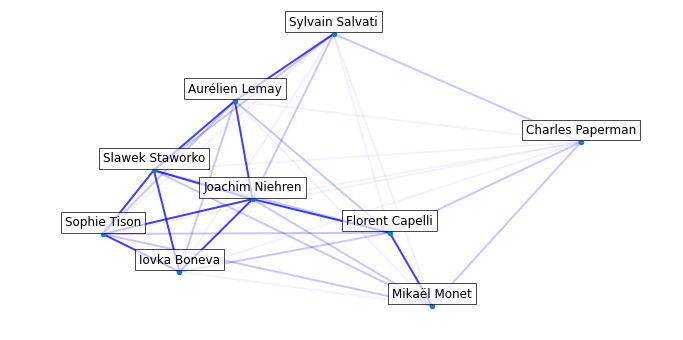

In [89]:
draw_nice_graph(LinksGraph)